# CS108/212 STAT108/212 W26 Course Project

### Team Details

- Teammate 1: Xiyuan Yu
- Teammate 2: Daniel Maciel
- Teammate 3: Byron Bhuiyan
- Teammate 4: Name

---


# Milestone: Mitigating Bias
For this project milestone, each teammate will implement bias mitigation strategies and assess pre and post bias mitigation performance.

# Installs

In [6]:
!pip install fairlearn -q

# Imports

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import collections
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference, MetricFrame
from fairlearn.postprocessing import ThresholdOptimizer
from sklearn.tree import DecisionTreeClassifier

# Loading dataset
_(same as previous milestone, copy-paste)_

In [ ]:
df = pd.read_csv("../fair_recrutment_dataset final.csv")


df = df.dropna().drop_duplicates().reset_index(drop=True)

X = df.drop(['Hiring_Decision', 'Candidate_ID'], axis=1)   # features
y = df['Hiring_Decision']                                   # target
sensitive_feature_colname = ['Gender', 'Age_Group']         # both sensitive features


group_labels = None

print(f"No. of samples: {df.shape[0]}")
print(f"No. of features: {X.shape[1]}")
print(df['Hiring_Decision'].value_counts().rename({0: 'Not Hired', 1: 'Hired'}))

No. of samples: 119971
No. of features: 14
Hiring_Decision
Not Hired    89086
Hired        30885
Name: count, dtype: int64


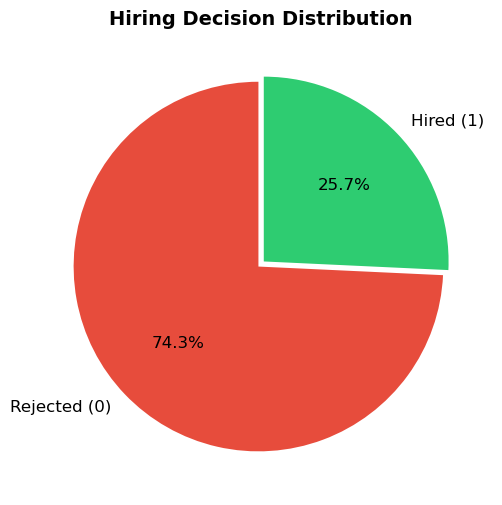

Total Candidates: 119,971
Hired:    30,885 (25.7%)
Rejected: 89,086 (74.3%)


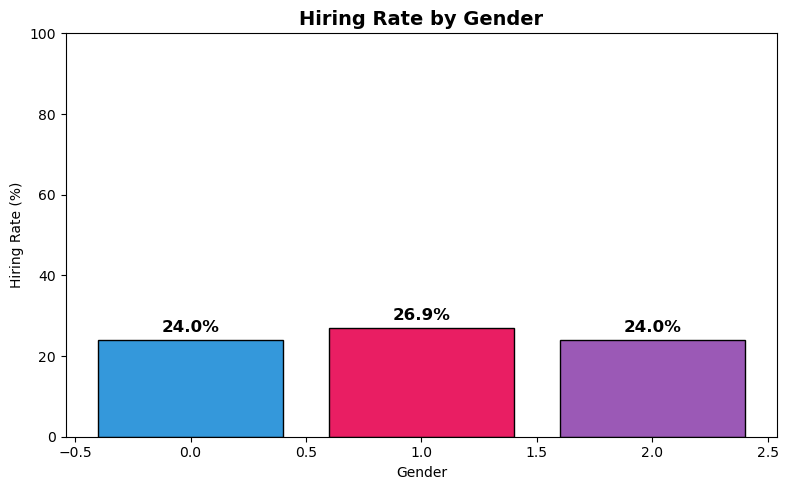

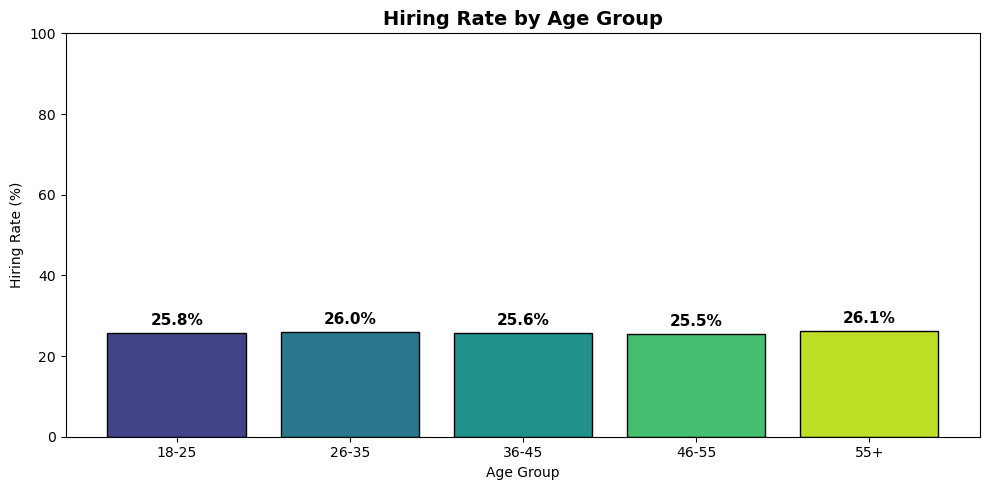

C:\Users\rafid\AppData\Local\Temp\ipykernel_33428\1733039186.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot(data, labels=["Female", "Male"], patch_artist=True)
C:\Users\rafid\AppData\Local\Temp\ipykernel_33428\1733039186.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot(data, labels=["Female", "Male"], patch_artist=True)
C:\Users\rafid\AppData\Local\Temp\ipykernel_33428\1733039186.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[idx].boxplot(data, labels=["Female", "Male"], patch_artist=True)
C:\Users\rafid\AppData\Local\Temp\ipykernel_33428\17330391

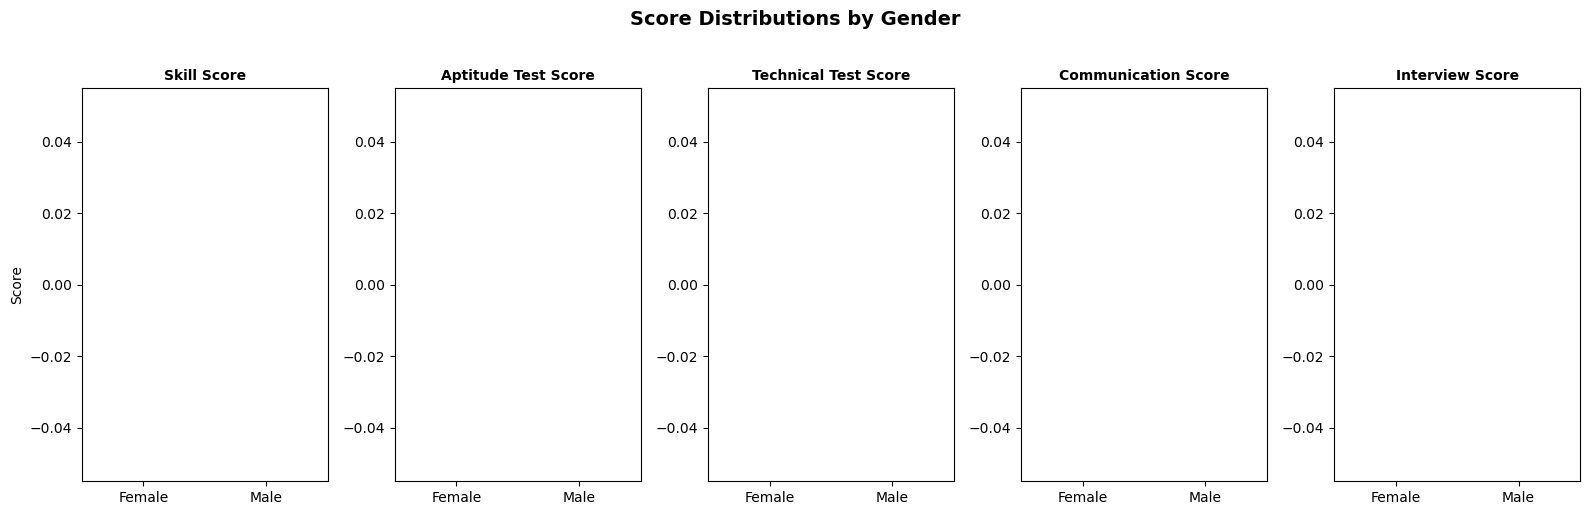

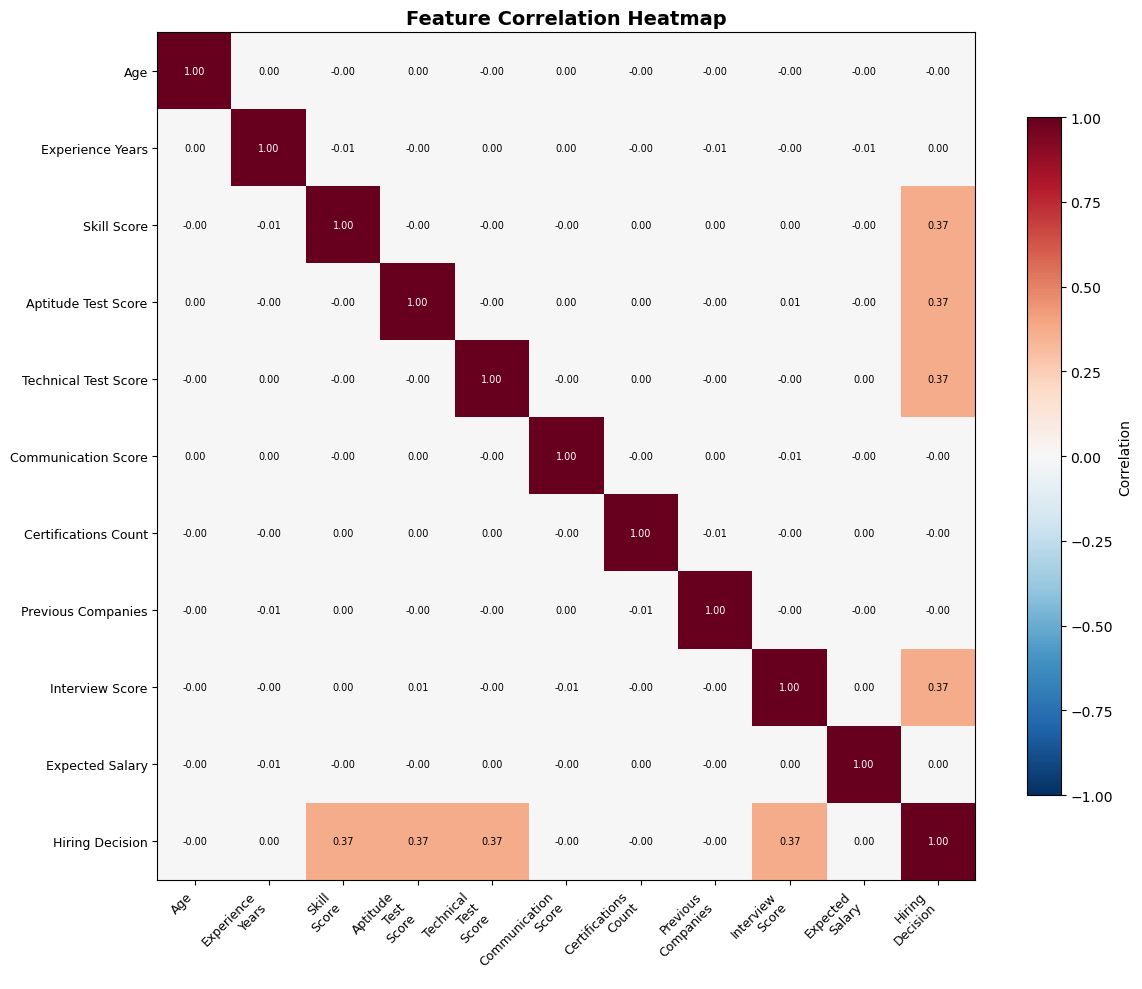

In [ ]:

hiring_counts = df["Hiring_Decision"].value_counts()
colors = ["#e74c3c", "#2ecc71"]
labels_pie = ["Rejected (0)", "Hired (1)"]

plt.figure(figsize=(6, 6))
plt.pie([hiring_counts[0], hiring_counts[1]], labels=labels_pie, colors=colors,
        autopct="%1.1f%%", startangle=90, explode=(0.02, 0.02),
        textprops={"fontsize": 12})
plt.title("Hiring Decision Distribution", fontsize=14, fontweight="bold")
plt.show()

print(f"Total Candidates: {len(df):,}")
print(f"Hired:    {hiring_counts[1]:,} ({hiring_counts[1]/len(df)*100:.1f}%)")
print(f"Rejected: {hiring_counts[0]:,} ({hiring_counts[0]/len(df)*100:.1f}%)")
gender_hiring = df.groupby("Gender")["Hiring_Decision"].agg(["sum", "count"])
gender_hiring["Hiring_Rate"] = (gender_hiring["sum"] / gender_hiring["count"] * 100).round(1)
gender_hiring = gender_hiring.reset_index()

plt.figure(figsize=(8, 5))
bars = plt.bar(gender_hiring["Gender"], gender_hiring["Hiring_Rate"],
               color=["#3498db", "#e91e63", "#9b59b6"], edgecolor="black")
plt.title("Hiring Rate by Gender", fontsize=14, fontweight="bold")
plt.ylabel("Hiring Rate (%)"); plt.xlabel("Gender"); plt.ylim(0, 100)
for bar, rate in zip(bars, gender_hiring["Hiring_Rate"]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
             f"{rate}%", ha="center", fontweight="bold", fontsize=12)
plt.tight_layout(); plt.show()
_bins  = [0, 25, 35, 45, 55, 100]
_labs  = ["18-25", "26-35", "36-45", "46-55", "55+"]
df["Age_Group_EDA"] = pd.cut(df["Age"], bins=_bins, labels=_labs)

age_hiring = df.groupby("Age_Group_EDA", observed=True)["Hiring_Decision"].agg(["sum", "count"])
age_hiring["Hiring_Rate"] = (age_hiring["sum"] / age_hiring["count"] * 100).round(1)
age_hiring = age_hiring.reset_index()

plt.figure(figsize=(10, 5))
colors_age = plt.cm.viridis([0.2, 0.4, 0.5, 0.7, 0.9])
bars = plt.bar(age_hiring["Age_Group_EDA"], age_hiring["Hiring_Rate"],
               color=colors_age, edgecolor="black")
plt.title("Hiring Rate by Age Group", fontsize=14, fontweight="bold")
plt.ylabel("Hiring Rate (%)"); plt.xlabel("Age Group"); plt.ylim(0, 100)
for bar, rate in zip(bars, age_hiring["Hiring_Rate"]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
             f"{rate}%", ha="center", fontweight="bold", fontsize=11)
plt.tight_layout(); plt.show()

df.drop(columns=["Age_Group_EDA"], inplace=True)  # clean up temp column

score_columns = ["Skill_Score", "Aptitude_Test_Score", "Technical_Test_Score",
                 "Communication_Score", "Interview_Score"]

fig, axes = plt.subplots(1, 5, figsize=(16, 5))
for idx, col in enumerate(score_columns):
    data = [df[df["Gender"] == "Female"][col], df[df["Gender"] == "Male"][col]]
    bp = axes[idx].boxplot(data, labels=["Female", "Male"], patch_artist=True)
    for patch, color in zip(bp["boxes"], ["#e91e63", "#3498db"]):
        patch.set_facecolor(color); patch.set_alpha(0.7)
    axes[idx].set_title(col.replace("_", " "), fontsize=10, fontweight="bold")
    axes[idx].set_ylabel("Score" if idx == 0 else "")
plt.suptitle("Score Distributions by Gender", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout(); plt.show()
numerical_cols = ["Age", "Experience_Years", "Skill_Score", "Aptitude_Test_Score",
                  "Technical_Test_Score", "Communication_Score", "Certifications_Count",
                  "Previous_Companies", "Interview_Score", "Expected_Salary", "Hiring_Decision"]

corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(12, 10))
cmap = plt.cm.RdBu_r
im = plt.imshow(corr_matrix, cmap=cmap, aspect="auto", vmin=-1, vmax=1)
plt.colorbar(im, label="Correlation", shrink=0.8)
plt.xticks(range(len(numerical_cols)),
           [c.replace("_", "\n") for c in numerical_cols], rotation=45, ha="right", fontsize=9)
plt.yticks(range(len(numerical_cols)),
           [c.replace("_", " ") for c in numerical_cols], fontsize=9)
for i in range(len(numerical_cols)):
    for j in range(len(numerical_cols)):
        val = corr_matrix.iloc[i, j]
        color = "white" if abs(val) > 0.5 else "black"
        plt.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=7, color=color)
plt.title("Feature Correlation Heatmap", fontsize=14, fontweight="bold")
plt.tight_layout(); plt.show()

# Preparing dataset
_(same as previous milestone, copy-paste)_

In [ ]:

edu_map = {'High School': 0, 'Diploma': 1, 'Bachelors': 2, 'Masters': 3, 'PhD': 4}
df['Education_Level'] = df['Education_Level'].map(edu_map)


df['Gender']           = LabelEncoder().fit_transform(df['Gender'])
df['Location']         = LabelEncoder().fit_transform(df['Location'])
df['Job_Role_Applied'] = LabelEncoder().fit_transform(df['Job_Role_Applied'])

bins = [20, 25, 35, 45, 55, 60]
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=[0, 1, 2, 3, 4],
                          include_lowest=True).astype(int)

X = df.drop(['Hiring_Decision', 'Candidate_ID'], axis=1)

group_labels = df['Gender'].astype(str) + '_age' + df['Age_Group'].astype(str)

print("Encoding complete. Sample group labels:")
print(group_labels.value_counts().head(8))

Encoding complete. Sample group labels:
1_age2    18460
1_age3    18416
1_age1    18323
0_age2    10854
0_age3    10771
0_age1    10697
1_age0     9264
1_age4     7478
Name: count, dtype: int64


# Getting training and testing sets

Note: Train-test split is made **ONCE** to obtain the _training set_ and the _testing set_ and every teammate will use the training set to train their baseline model and test the trained model using the testing set. **NEVER** modify the testing set once it has been created.
Therefore, the following code cell does not need to be edited.

_(same as previous milestone, copy-paste)_

In [11]:
X_train, X_test, \
  y_train, y_test, \
    group_labels_train, group_labels_test = train_test_split(X, y, group_labels,
                                                             test_size=0.2, random_state=42)

print(f"No. of training samples: {X_train.shape[0]}")
print(f"No. of testing samples: {X_test.shape[0]}")

# Delete X, y and group_label variables to make sure they are not used later on.
del X
del y
del group_labels

No. of training samples: 95976
No. of testing samples: 23995


# Setting up evaluation metrics
Note: The same evaluation function will be used by all teammates.

_(same as previous milestone, copy-paste)_

In [12]:
def evaluate_model(y_test, y_pred, g_labels):
    """
    Evaluate model performance and fairness on the testing set.

    Parameters
    ----------
    y_test    : array-like — true labels
    y_pred    : array-like — predicted labels
    g_labels  : array-like — combined sensitive group labels (Gender x Age_Group)

    Returns
    -------
    results : dict with accuracy, f1_score, demographic_parity_diff, equalized_odds_diff
    """
    results = {}

    # Task-specific performance metrics
    results['accuracy'] = accuracy_score(y_test, y_pred)
    results['f1_score'] = f1_score(y_test, y_pred)

    # Fairness metrics across Gender x Age_Group groups
    results['demographic_parity_diff'] = demographic_parity_difference(
        y_test, y_pred, sensitive_features=g_labels)
    results['equalized_odds_diff'] = equalized_odds_difference(
        y_test, y_pred, sensitive_features=g_labels)

    return results

# Training baseline models (INDIVIDUAL CONTRIBUTION)
_(minor modifications from previous milestone)_

In [13]:
## A place to save all teammates's baseline results
all_baseline_results = [] ## DO NOT EDIT

## Teammate 1

{'accuracy': 0.9596582621379454,
 'demographic_parity_diff': 0.0689329176304938,
 'equalized_odds_diff': 0.08784021071115011,
 'experiment_type': 'baseline',
 'f1_score': 0.9223487887052784,
 'mitigation_strategy': 'none',
 'predictor_model': 'Decision Tree',
 'teammate': 'Teammate 1'}


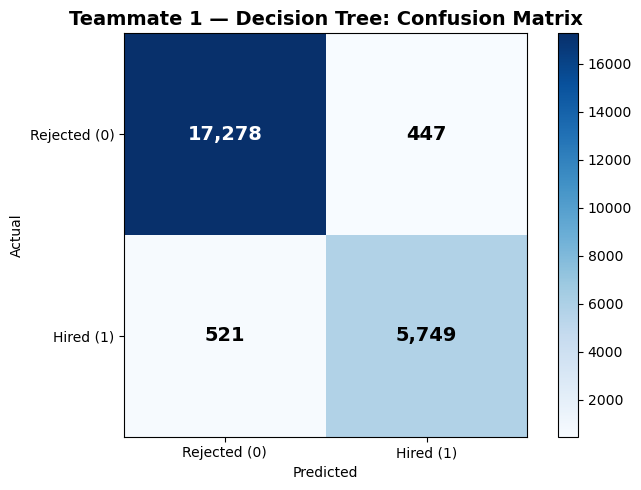

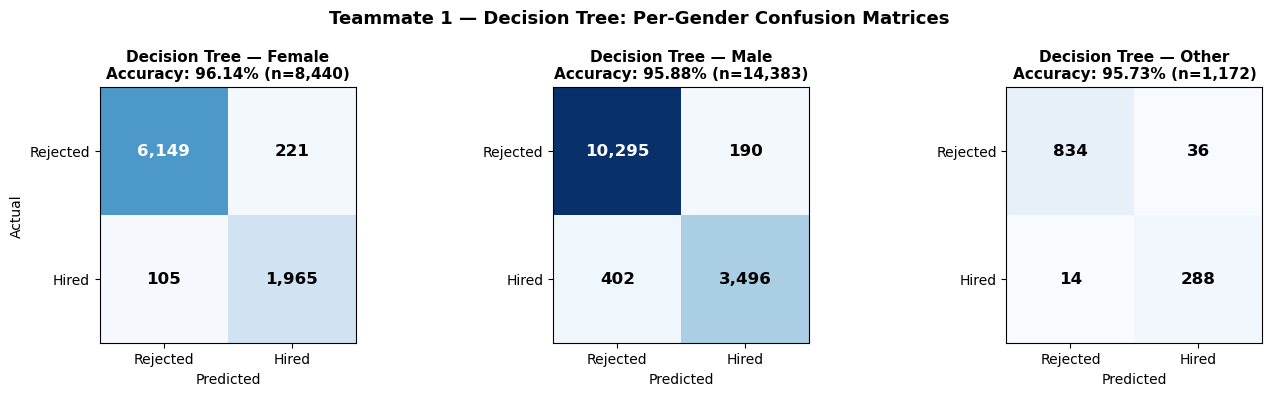

FAIRNESS METRICS BY GENDER — Decision Tree
        TPR (Recall)     FPR     FNR  TNR (Specificity)  PPV (Precision)  Accuracy  Selection Rate
Gender                                                                                            
Female        0.9493  0.0347  0.0507             0.9653           0.8989    0.9614          0.2590
Male          0.8969  0.0181  0.1031             0.9819           0.9485    0.9588          0.2563
Other         0.9536  0.0414  0.0464             0.9586           0.8889    0.9573          0.2765


In [ ]:
# Decision Tree Baseline
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=1)
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)


results = evaluate_model(y_test, y_pred, group_labels_test)


results['teammate']            = 'Teammate 1'
results['experiment_type']     = 'baseline'
results['predictor_model']     = 'Decision Tree'
results['mitigation_strategy'] = 'none'
all_baseline_results.append(results)

pprint(results)


conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
plt.imshow(conf_matrix, cmap="Blues")
plt.colorbar()
plt.title("Teammate 1 — Decision Tree: Confusion Matrix", fontsize=14, fontweight="bold")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.xticks([0, 1], ["Rejected (0)", "Hired (1)"])
plt.yticks([0, 1], ["Rejected (0)", "Hired (1)"])
for i in range(2):
    for j in range(2):
        color = "white" if conf_matrix[i, j] > conf_matrix.max()/2 else "black"
        plt.text(j, i, f"{conf_matrix[i, j]:,}", ha="center", va="center",
                 color=color, fontsize=14, fontweight="bold")
plt.tight_layout(); plt.show()


gender_labels_map = {0: "Female", 1: "Male", 2: "Other"}
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
all_cms = [confusion_matrix(y_test[X_test["Gender"] == g],
                             y_pred[X_test["Gender"] == g])
           for g in gender_labels_map]
vmax = max(cm.max() for cm in all_cms)

for idx, (g_code, g_name) in enumerate(gender_labels_map.items()):
    mask = X_test["Gender"] == g_code
    cm_g = confusion_matrix(y_test[mask], y_pred[mask])
    acc_g = (cm_g[0,0] + cm_g[1,1]) / cm_g.sum()
    im = axes[idx].imshow(cm_g, cmap="Blues", vmin=0, vmax=vmax)
    axes[idx].set_title(f"Decision Tree — {g_name}\nAccuracy: {acc_g:.2%} (n={mask.sum():,})",
                        fontsize=11, fontweight="bold")
    axes[idx].set_xlabel("Predicted"); axes[idx].set_ylabel("Actual" if idx == 0 else "")
    axes[idx].set_xticks([0,1]); axes[idx].set_xticklabels(["Rejected","Hired"])
    axes[idx].set_yticks([0,1]); axes[idx].set_yticklabels(["Rejected","Hired"])
    for i in range(2):
        for j in range(2):
            color = "white" if cm_g[i,j] > vmax/2 else "black"
            axes[idx].text(j, i, f"{cm_g[i,j]:,}", ha="center", va="center",
                          color=color, fontsize=12, fontweight="bold")
plt.suptitle("Teammate 1 — Decision Tree: Per-Gender Confusion Matrices",
             fontsize=13, fontweight="bold")
plt.tight_layout(); plt.show()


from sklearn.metrics import confusion_matrix as _cm

fairness_rows = []
for g_code, g_name in gender_labels_map.items():
    mask = X_test["Gender"] == g_code
    tn, fp, fn, tp = _cm(y_test[mask], y_pred[mask]).ravel()
    fairness_rows.append({
        "Gender":            g_name,
        "TPR (Recall)":      tp/(tp+fn) if (tp+fn) > 0 else 0,
        "FPR":               fp/(fp+tn) if (fp+tn) > 0 else 0,
        "FNR":               fn/(fn+tp) if (fn+tp) > 0 else 0,
        "TNR (Specificity)": tn/(tn+fp) if (tn+fp) > 0 else 0,
        "PPV (Precision)":   tp/(tp+fp) if (tp+fp) > 0 else 0,
        "Accuracy":          (tp+tn)/(tp+tn+fp+fn),
        "Selection Rate":    (tp+fp)/(tp+tn+fp+fn),
    })

fairness_df = pd.DataFrame(fairness_rows).set_index("Gender").round(4)
print("=" * 60)
print("FAIRNESS METRICS BY GENDER — Decision Tree")
print("=" * 60)
print(fairness_df.to_string())

## Teammate 2

{'accuracy': 0.9136486768076683,
 'demographic_parity_diff': 0.09402482536810894,
 'equalized_odds_diff': 0.21723063928627984,
 'experiment_type': 'baseline',
 'f1_score': 0.8020634314100115,
 'mitigation_strategy': 'none',
 'predictor_model': 'Naive Bayes (GaussianNB)',
 'teammate': 'Teammate 2'}


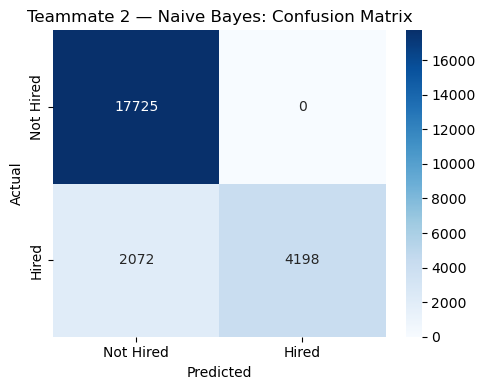

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

y_pred = nb_model.predict(X_test)


results = evaluate_model(y_test, y_pred, group_labels_test)


results['teammate']            = 'Teammate 2'
results['experiment_type']     = 'baseline'
results['predictor_model']     = 'Naive Bayes (GaussianNB)'
results['mitigation_strategy'] = 'none'
all_baseline_results.append(results)

pprint(results)


from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Hired', 'Hired'],
            yticklabels=['Not Hired', 'Hired'])
plt.title('Teammate 2 — Naive Bayes: Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.tight_layout(); plt.show()

{'accuracy': 0.9934152948530944,
 'demographic_parity_diff': 0.0962612609439823,
 'equalized_odds_diff': 0.05454545454545454,
 'experiment_type': 'baseline',
 'f1_score': 0.9874003189792664,
 'mitigation_strategy': 'none',
 'predictor_model': 'Logistic Regression',
 'teammate': 'Teammate 3'}


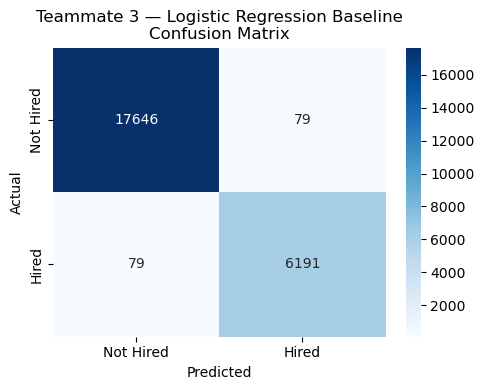


Per-group metrics (top 10 groups):
                     accuracy        f1
sensitive_feature_0                    
2_age2               0.959596  0.915493
2_age1               0.960656  0.934066
2_age0               0.962687  0.938272
2_age3               0.967105  0.940476
2_age4               0.969697  0.945946
0_age4               0.993197  0.985981
1_age1               0.993414  0.987718
1_age4               0.993785  0.988387
0_age3               0.993934  0.988171
1_age3               0.994068  0.988695


In [ ]:
# Logistic Regression Baseline

lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, random_state=9867))
])

lr_pipeline.fit(X_train, y_train)


y_pred = lr_pipeline.predict(X_test)


results = evaluate_model(y_test, y_pred, group_labels_test)


results['teammate']            = 'Teammate 3'
results['experiment_type']     = 'baseline'
results['predictor_model']     = 'Logistic Regression'
results['mitigation_strategy'] = 'none'
all_baseline_results.append(results)

pprint(results)


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Hired', 'Hired'],
            yticklabels=['Not Hired', 'Hired'])
plt.title('Teammate 3 — Logistic Regression Baseline\nConfusion Matrix')
plt.ylabel('Actual'); plt.xlabel('Predicted')
plt.tight_layout(); plt.show()


mf = MetricFrame(
    metrics={'accuracy': accuracy_score, 'f1': f1_score},
    y_true=y_test, y_pred=y_pred,
    sensitive_features=group_labels_test
)
print("\nPer-group metrics (top 10 groups):")
print(mf.by_group.sort_values('accuracy').head(10))

## Teammate 4

In [ ]:
# Select a model and train it on the training set
# [INSERT YOUR CODE HERE]

# Make predictions on the testing set and store them in y_pred
y_pred = ... # [INSERT CODE HERE]

# Evaluate testing set predictions using evaluate_model()
results = evaluate_model(y_test, y_pred, group_labels_test)

# Save your results to all_baseline_results
results['teammate'] = 'Teammate 4'
results['experiment_type'] = 'baseline'
results['predictor_model'] = ... #[INSERT MODEL NAME HERE]
results['mitigation_strategy'] = 'NONE' ## DO NOT EDIT: This is pre-mitigation baseline
all_baseline_results.append(results)

pprint(results)

# Mitigating Bias (INDIVIDUAL CONTRIBUTION)

_(new in this milestone)_


In [11]:
## A place to save all teammates' post-mitigation results
all_mitigated_results = [] ## DO NOT EDIT

## Teammate 1

In [ ]:
# Implement your bias mitigation strategy
## If you chose preprocessing, you will train a new version of your predictor model with new/modified inputs.
## If you chose inprocessing, you will train a new version of your predictor with modified learning objective (loss function).
## If you chose postprocessing, you will implement strategies to modify the predictions (y_pred) of the trained baseline predictor model from the previous milestone without training any new version of the predictor model.

# [INSERT CODE HERE]

# Make predictions on the testing set and store them in y_pred_mitigate
y_pred_mitigated = ... # [INSERT CODE HERE]

# Evaluate testing set predictions using evaluate_model()
results_mitigated = evaluate_model(y_test, y_pred_mitigated, group_labels_test)

# Save your results to all_mitigated_results
results_mitigated['teammate'] = 'Teammate 1'
results_mitigated['experiment_type'] = 'post-mitigation'
results_mitigated['predictor_model'] = ... #[INSERT MODEL NAME HERE]
results_mitigated['mitigation_strategy'] = ... #[INSERT STRATEGY TYPE HERE: 'preprocessing', 'inprocessing', 'postprocessing']
all_mitigated_results.append(results_mitigated)

pprint(results_mitigated)

### Teammate 1's Conclusions
[Briefly describe findings and conclusions here. Compare post-mitigation results with baseline results for your model. What is the % improvement in performance post-mitigation?  ]

## Teammate 2

In [ ]:
# Implement your bias mitigation strategy
## If you chose preprocessing, you will train a new version of your predictor model with new/modified inputs.
## If you chose inprocessing, you will train a new version of your predictor with modified learning objective (loss function).
## If you chose postprocessing, you will implement strategies to modify the predictions (y_pred) of the trained baseline predictor model from the previous milestone without training any new version of the predictor model.

# [INSERT CODE HERE]

# Make predictions on the testing set and store them in y_pred_mitigate
y_pred_mitigated = ... # [INSERT CODE HERE]

# Evaluate testing set predictions using evaluate_model()
results_mitigated = evaluate_model(y_test, y_pred_mitigated, group_labels_test)

# Save your results to all_mitigated_results
results_mitigated['teammate'] = 'Teammate 2'
results_mitigated['experiment_type'] = 'post-mitigation'
results_mitigated['predictor_model'] = ... #[INSERT MODEL NAME HERE]
results_mitigated['mitigation_strategy'] = ... #[INSERT STRATEGY TYPE HERE: 'preprocessing', 'inprocessing', 'postprocessing']
all_mitigated_results.append(results_mitigated)

print(results_mitigated)

### Teammate 2's Conclusions
[Briefly describe findings and conclusions here. Compare post-mitigation results with baseline results for your model. What is the % improvement in performance post-mitigation?]


## Teammate 3

In [ ]:
# Implement your bias mitigation strategy
## If you chose preprocessing, you will train a new version of your predictor model with new/modified inputs.
## If you chose inprocessing, you will train a new version of your predictor with modified learning objective (loss function).
## If you chose postprocessing, you will implement strategies to modify the predictions (y_pred) of the trained baseline predictor model from the previous milestone without training any new version of the predictor model.

# [INSERT CODE HERE]

# Make predictions on the testing set and store them in y_pred_mitigate
y_pred_mitigated = ... # [INSERT CODE HERE]

# Evaluate testing set predictions using evaluate_model()
results_mitigated = evaluate_model(y_test, y_pred_mitigated, group_labels_test)

# Save your results to all_mitigated_results
results_mitigated['teammate'] = 'Teammate 2'
results_mitigated['experiment_type'] = 'post-mitigation'
results_mitigated['predictor_model'] = ... #[INSERT MODEL NAME HERE]
results_mitigated['mitigation_strategy'] = ... #[INSERT STRATEGY TYPE HERE: 'preprocessing', 'inprocessing', 'postprocessing']
all_mitigated_results.append(results_mitigated)

print(results_mitigated)

### Teammate 3's Conclusions
[Briefly describe findings and conclusions here. Compare post-mitigation results with baseline results for your model. What is the % improvement in performance post-mitigation?]

## Teammate 4

In [ ]:
# Implement your bias mitigation strategy
## If you chose preprocessing, you will train a new version of your predictor model with new/modified inputs.
## If you chose inprocessing, you will train a new version of your predictor with modified learning objective (loss function).
## If you chose postprocessing, you will implement strategies to modify the predictions (y_pred) of the trained baseline predictor model from the previous milestone without training any new version of the predictor model.

# [INSERT CODE HERE]

# Make predictions on the testing set and store them in y_pred_mitigate
y_pred_mitigated = ... # [INSERT CODE HERE]

# Evaluate testing set predictions using evaluate_model()
results_mitigated = evaluate_model(y_test, y_pred_mitigated, group_labels_test)

# Save your results to all_mitigated_results
results_mitigated['teammate'] = 'Teammate 4'
results_mitigated['experiment_type'] = 'post-mitigation'
results_mitigated['predictor_model'] = ... #[INSERT MODEL NAME HERE]
results_mitigated['mitigation_strategy'] = ... #[INSERT STRATEGY TYPE HERE: 'preprocessing', 'inprocessing', 'postprocessing']
all_mitigated_results.append(results_mitigated)

print(results_mitigated)

### Teammate 4's Conclusions
[Briefly describe findings and conclusions here. Compare post-mitigation results with baseline results for your model. What is the % improvement in performance post-mitigation?]


# Conclusions
_(new in this milestone)_


In [13]:
# Collect all the results in one table.
overall_results = pd.concat([pd.DataFrame(all_baseline_results), pd.DataFrame(all_mitigated_results)])
overall_results ## Note: The table displayed below in this starter notebook is for your reference, your team's table will be slightly different (e.g. different metrics, no.of sensitive attribute-based groups, actual values, etc.) upon successful completion of this notebook.

,accuracy,f1_score,demographic_parity_diff,equalized_odds_diff,teammate,experiment_type,predictor_model,mitigation_strategy
0,0.993415,0.9874,0.096261,0.054545,Teammate 3,baseline,Logistic Regression,none
0,1.000000,1.0000,0.070562,0.000000,Teammate 3,post-mitigation,Logistic Regression,postprocessing


[Briefly describe overall findings and conclusions here. Which mitigation strategy resulted in most improvement? Which resulted in the least improvement? Visualize the results with some informative plots. (Hint: Use the `overall_results` table).]

# References

[List the references you used to complete this milestone here.]
- Teammate 1:
- Teammate 2:
- Teammate 3:
- Teammate 4:

# Disclosures

[Disclose use of generative AI and similar tools here.]
- Teammate 1:
- Teammate 2:
- Teammate 3:
- Teammate 4: